In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gassuain Processes Regression (GPR):
We have noisy sensor readings (indicated by errorbars) and we want to predict  readings for desired new points. In GPs every new point will be a dimension to infinite dimensional multivariate gaussian distribution (usualy mean zero) in which covariance between points will be defined by the kernel function.
In other words, in GPs we can have infinte number of random variables, that any finite subset of them will be jointly gaussian as well. GP can then be called a distribution over functions where value of each function at a certain point will be a gussian RV. 

By fiting a GP to our (n) trainig points (observations) we can get then nearly back with a single sample from a n-dimentional GP.

Train set points:
$$\mathbf{x} = \begin{bmatrix}
x_1 & x_2 & \cdots & x_n
\end{bmatrix}$$
Test set points:
$$\mathbf{x}_* = \begin{bmatrix}
x_{1*} & x_{2*} & \cdots & x_{m*}
\end{bmatrix}$$
Kernel function with integrated reading noise:
$$ k(x,x') = \sigma_f^2 e^{\frac{-(x-x')^2}{2l^2}} + \sigma_n^2\delta(x,x')$$
and then our GP kernel will read:
\begin{equation*}
\begin{bmatrix}
\mathbf{y}\\
\mathbf{y}_*
\end{bmatrix}
\sim N\Bigl(
0,\begin{bmatrix}
\mathbf{K} & \mathbf{K}_*^T \\
\mathbf{K}_* & \mathbf{K}_{**} \\
\end{bmatrix}
)
\end{equation*}
where 

$$\mathbf{K} = \begin{bmatrix}
k(x_1,x_1) & k(x_1,x_2) & \cdots & k(x_1,x_n) \\
k(x_2,x_1) & k(x_2,x_2) & \cdots & k(x_2,x_n) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_n,x_1) & k(x_n,x_2) & \cdots & k(x_n,x_n) \\\end{bmatrix}$$

$$\mathbf{K}_* = \begin{bmatrix}
k(x_{1*},x_1) & k(x_{1*},x_2) & \cdots & k(x_{1*},x_n) \\
k(x_{2*},x_1) & k(x_{2*},x_2) & \cdots & k(x_{2*},x_n) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_{m*},x_1) & k(x_{m*},x_2) & \cdots & k(x_{m*},x_n) \\\end{bmatrix}$$

$$\mathbf{K}_{**} = \begin{bmatrix}
k(x_{1*},x_{1*}) & k(x_{1*},x_{2*}) & \cdots & k(x_{1*},x_{m*}) \\
k(x_{2*},x_{1*}) & k(x_{2*},x_{2*}) & \cdots & k(x_{2*},x_{m*}) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_{m*},x_{1*}) & k(x_{m*},x_{2*}) & \cdots & k(x_{m*},x_{m*}) \\ \end{bmatrix}$$

Next, for prediction we are interested to know the conditional probability of $y_*$ given data which will also follow a gaussian distribution acroding to equation below:
$$y_* \vert y \sim N\Bigl(K_*K^{-1}y,K_{**}-K_*K^{-1}K_*^T)$$
the mean will be our best estimate and the variance will indicate our uncertainty.

We will define kernel function here:

In [3]:
def get_kernel(X1,X2,sigmaf,l,sigman):
    k = lambda x1,x2,sigmaf,l,sigman:(sigmaf**2)*np.exp(-(1/float(2*(l**2)))*np.dot((x1-x2),(x1-x2).T)) + (sigman**2);
    K = np.zeros((X1.shape[0],X2.shape[0]))
    for i in range(0,X1.shape[0]):
        for j in range(0,X2.shape[0]):
            if i==j:
                K[i,j] = k(X1[i,:],X2[j,:],sigmaf,l,sigman);
            else:
                K[i,j] = k(X1[i,:],X2[j,:],sigmaf,l,0);
    return K

## Single point prediction with GPR
We wont use optimized kernel hyperparameters here and only guess some values and predict the target for a single point.

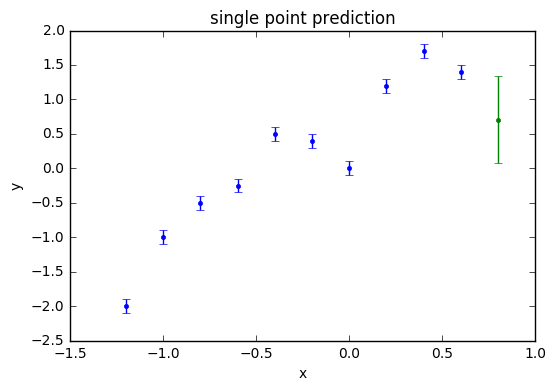

In [4]:
n_pts = 1

x = np.array([-1.2, -1., -0.8, -0.6, -.4, -0.2, 0.0, 0.2, 0.4, 0.6],ndmin=2).T
y = np.array([-2, -1, -0.5, -0.25, 0.5, 0.4, 0.0, 1.2, 1.7, 1.4],ndmin=2).T
x_predict = np.array([0.8,]).reshape(n_pts,1)

sigman = 0.1; # noise of the reading
sigmaf = 1.1; # parameters of the GP - next to be computed by optimization
l = 0.2; #lenght-scale of our GP with squared exponential kernel

K = get_kernel(x, x, sigmaf, l, sigman) #+ np.finfo(float).eps*np.identity(x.size) # numerically stable
K_s = get_kernel(x_predict, x, sigmaf, l, 0)
K_ss = get_kernel(x_predict, x_predict, sigmaf, l, sigman)

y_predict_mean = np.dot(np.dot(K_s,np.linalg.inv(K)),y).reshape(n_pts,1)
y_predict_var = np.diag(K_ss - np.dot(K_s,(np.dot(np.linalg.inv(K),K_s.T)))).reshape(n_pts,1)

plt.errorbar(x[:,0], y[:,0], sigman*np.ones_like(y),linestyle='None',marker = '.')

plt.errorbar(x_predict[:,0], y_predict_mean[:,0], y_predict_var[:,0], linestyle='None',marker = '.')
plt.xlabel('x');plt.ylabel('y');plt.title('single point prediction')
plt.show()

In [5]:
y_predict_var.shape

(1, 1)

 Next we will predict 100 points:

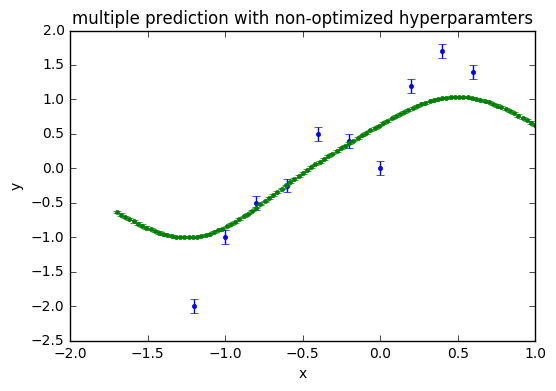

In [6]:
n_pts = 100
sigmaf=.1; l=0.5;

x_predict = np.linspace(-1.7,1,n_pts).reshape(n_pts,1)

K = get_kernel(x, x, sigmaf, l, sigman) #+ np.finfo(float).eps*np.identity(x.size) # numerically stable
K_s = get_kernel(x_predict, x, sigmaf, l, 0)
K_ss = get_kernel(x_predict, x_predict, sigmaf, l, sigman)

y_predict_mean = np.dot(np.dot(K_s,np.linalg.inv(K)),y).reshape(n_pts,1)
y_predict_var = np.diag(K_ss - np.dot(K_s,(np.dot(np.linalg.inv(K),K_s.T)))).reshape(n_pts,1)

plt.errorbar(x[:,0], y[:,0], sigman*np.ones_like(y),linestyle='None',marker = '.')

plt.errorbar(x_predict[:,0], y_predict_mean[:,0], y_predict_var[:,0], linestyle='None',marker = '.')
plt.xlabel('x');plt.ylabel('y');plt.title('multiple prediction with non-optimized hyperparamters');
plt.show()

## GPR parameter optimization

Our last model doesn't fit the data that well and that is because kernel parameters aren' adjusted according to data need.

To address this probelm we will determine the best hyperparameters of our GP. We will use MAP estimate:

$$log p(y \vert x,\theta) = -\frac{1}{2}(y^TK^{-1}y-log(det(K))-nlog2\pi) $$

In [13]:
p = [1, 0.1]; # inital start point

fun = lambda p: 0.5*(np.dot(y.T,np.dot(np.linalg.inv(get_kernel(x,x,p[0],p[1],sigman)),y)) + np.log(np.linalg.det(get_kernel(x,x,p[0],p[1],sigman))) + x.shape[0]*np.log(2*np.pi));
p = fmin(func=fun, x0=p)
sigmaf, l = p;

print sigmaf,l

Optimization terminated successfully.
         Current function value: 10.083924
         Iterations: 36
         Function evaluations: 70
1.13552126798 0.255757281646


With current optimized parameters we will check our GP again:

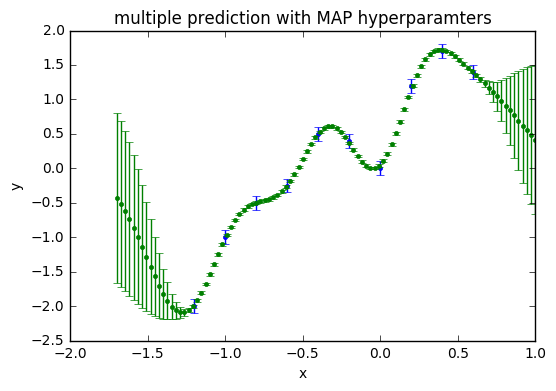

In [14]:
K = get_kernel(x, x, sigmaf, l, sigman) #+ np.finfo(float).eps*np.identity(x.size) # numerically stable
K_s = get_kernel(x_predict, x, sigmaf, l, 0)
K_ss = get_kernel(x_predict, x_predict, sigmaf, l, sigman)

y_predict_mean = np.dot(np.dot(K_s,np.linalg.inv(K)),y).reshape(n_pts,1)
y_predict_var = np.diag(K_ss - np.dot(K_s,(np.dot(np.linalg.inv(K),K_s.T)))).reshape(n_pts,1)

plt.errorbar(x[:,0], y[:,0], sigman*np.ones_like(y),linestyle='None',marker = '.')

plt.errorbar(x_predict[:,0], y_predict_mean[:,0], y_predict_var[:,0], linestyle='None',marker = '.')
plt.xlabel('x');plt.ylabel('y');plt.title('multiple prediction with MAP hyperparamters')
plt.show()

much better right!!?

note that in the ends when there are no training training data the uncertainty increases as we go far from the last training point.

##### Reference: Gaussian Processes for Machine Learning Carl Edward Rasmussen and Christopher K. I. Williams The MIT Press, 2006.